In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import statsmodels.api as sm

In [2]:
# Combine TLE CSVs
file_list = glob.glob('../data/tles/*.csv')
df_list = []
for file in file_list:
    df = pd.read_csv(file)
    df_list.append(df)

In [3]:
all_tle_df = pd.concat(df_list, ignore_index=True)
all_tle_df.drop_duplicates(inplace=True)

In [4]:
# Convery EPOCH to datetime
all_tle_df['EPOCH'] = pd.to_datetime(all_tle_df['EPOCH'], errors='coerce')
all_tle_df.dropna(subset=['EPOCH'], inplace=True)

In [5]:
# Save merged TLEs
all_tle_df.to_csv('../data/all_tle_merged.csv', index=False)

In [6]:
# Load and Clean Decay Data
decay_df = pd.read_csv('../data/decay_data.csv')
decay_df = decay_df[['NORAD_CAT_ID', 'DECAY_EPOCH']]
decay_df['DECAY_EPOCH'] = pd.to_datetime(decay_df['DECAY_EPOCH'], errors='coerce')
decay_df.dropna(subset=['DECAY_EPOCH'], inplace=True)
decay_df

,NORAD_CAT_ID,DECAY_EPOCH
0,15830,2024-07-31 17:43:00
1,15830,2024-07-31 17:43:00
2,15830,2024-07-31 17:42:00
3,12755,2024-07-31 00:00:00
4,12755,2024-07-31 00:00:00
...,...,...
991,47599,2024-07-01 00:00:00
992,47644,2024-07-01 00:00:00
993,50284,2024-07-01 00:00:00
994,55694,2024-07-01 00:00:00


In [7]:
# Merge TLEs with Deccay Data
merged_df = all_tle_df.merge(decay_df, on='NORAD_CAT_ID', how='inner')

In [8]:
# Calculate days to decay, add it as a column
merged_df['days_to_decay'] = (merged_df['DECAY_EPOCH'] - merged_df['EPOCH']).dt.days
merged_df = merged_df[merged_df['days_to_decay'] >= 0]

In [9]:
# Save Features Dataset
features_df = merged_df[['NORAD_CAT_ID', 'EPOCH', 'MEAN_MOTION', 'ECCENTRICITY', 'INCLINATION', 'BSTAR', 'days_to_decay']]
features_df.to_csv('../data/features.csv', index=False)

### EDA

In [10]:
print('\n Data Preview:')
print(features_df.head())


 Data Preview:
   NORAD_CAT_ID               EPOCH  MEAN_MOTION  ECCENTRICITY  INCLINATION  \
0         13479 2024-07-24 23:30:00    16.142222      0.002116      82.8327   
1         13479 2024-07-24 23:30:00    16.142222      0.002116      82.8327   
2         13479 2024-07-24 23:30:00    16.142222      0.002116      82.8327   
3         13479 2024-07-24 23:30:00    16.142222      0.002116      82.8327   
4         13479 2024-07-24 23:30:00    16.142222      0.002116      82.8327   

      BSTAR  days_to_decay  
0  0.008575              4  
1  0.008575              4  
2  0.008575              0  
3  0.008575              0  
4  0.008575              0  


In [11]:
print('\n Data Info:')
print(features_df.info())


 Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 861985 entries, 0 to 862097
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   NORAD_CAT_ID   861985 non-null  int64         
 1   EPOCH          861985 non-null  datetime64[ns]
 2   MEAN_MOTION    861985 non-null  float64       
 3   ECCENTRICITY   861985 non-null  float64       
 4   INCLINATION    861985 non-null  float64       
 5   BSTAR          861985 non-null  float64       
 6   days_to_decay  861985 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 52.6 MB
None


In [12]:
print('\n Summary Statistics:')
print(features_df.describe())


 Summary Statistics:
        NORAD_CAT_ID                          EPOCH    MEAN_MOTION  \
count  861985.000000                         861985  861985.000000   
mean    24519.530458  2012-03-15 14:35:25.503019776      13.780547   
min     12755.000000            1979-07-18 07:55:00       2.305852   
25%     14819.000000            2003-12-17 23:07:00      14.337399   
50%     14819.000000            2016-04-20 22:37:00      14.872430   
75%     37159.000000            2022-05-19 11:04:00      15.182065   
max     58144.000000            2024-07-24 23:56:00      16.494439   
std     14945.850004                            NaN       3.220616   

        ECCENTRICITY    INCLINATION          BSTAR  days_to_decay  
count  861985.000000  861985.000000  861985.000000  861985.000000  
mean        0.064623      74.174317       0.000774    4514.456906  
min         0.000004      31.548600      -0.047933       0.000000  
25%         0.001158      71.170800       0.000080     797.000000  
50%    

In [13]:
print('\n Missing Values:')
print(features_df.isnull().sum())


 Missing Values:
NORAD_CAT_ID     0
EPOCH            0
MEAN_MOTION      0
ECCENTRICITY     0
INCLINATION      0
BSTAR            0
days_to_decay    0
dtype: int64


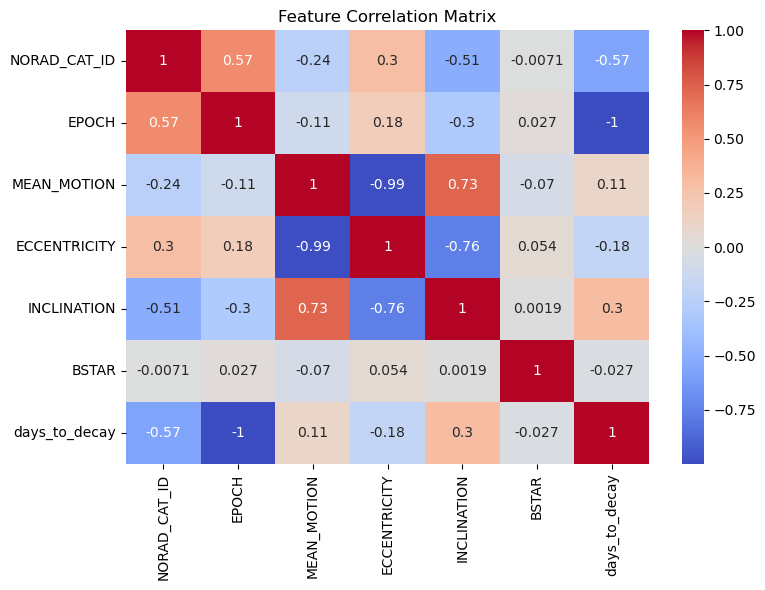

In [15]:
# Correlation Heatmap
fig, ax = plt.subplots(figsize=(8,6))
corr = features_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax)
ax.set_title('Feature Correlation Matrix')
plt.tight_layout()

This correlation heatmap suggests there may be strong negative correlations between eccentricity and mean_motion and eccentricity and inclination. It suggests somewhat strong positive correlations between inclincation and mean_motion. 

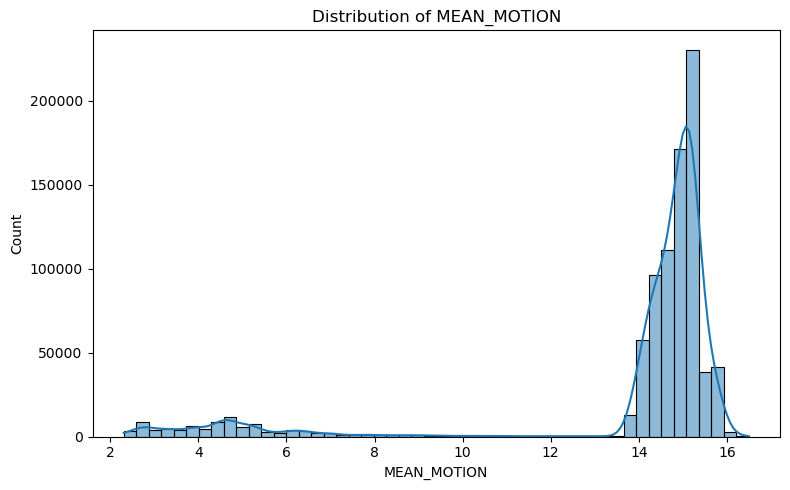

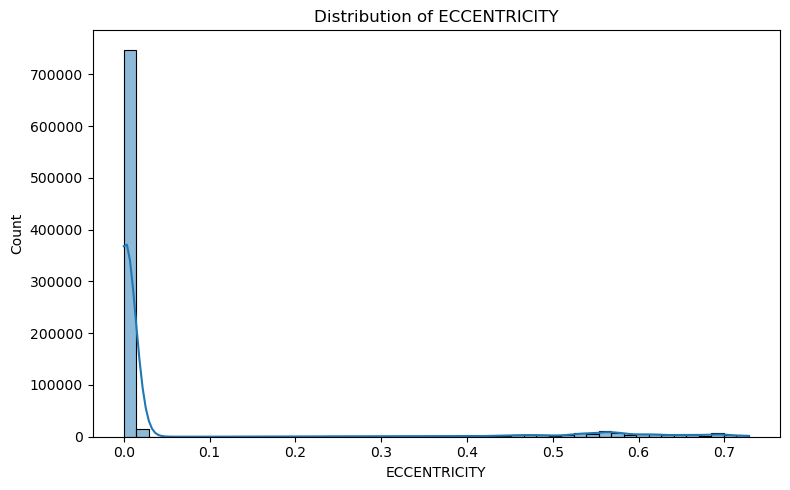

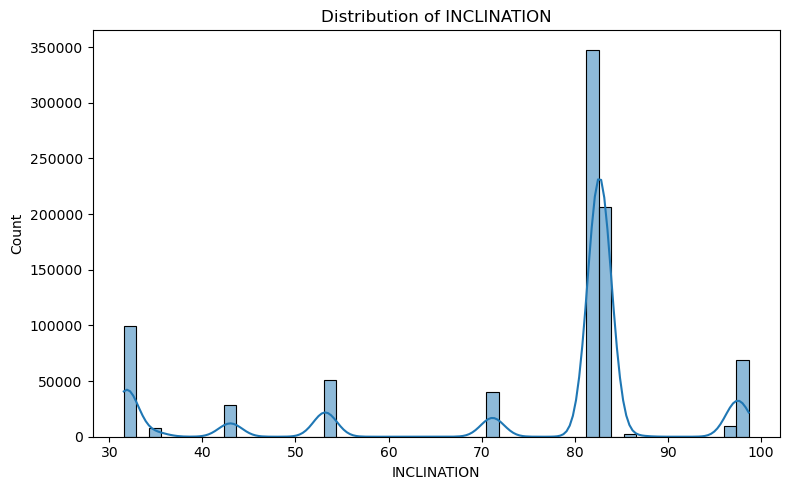

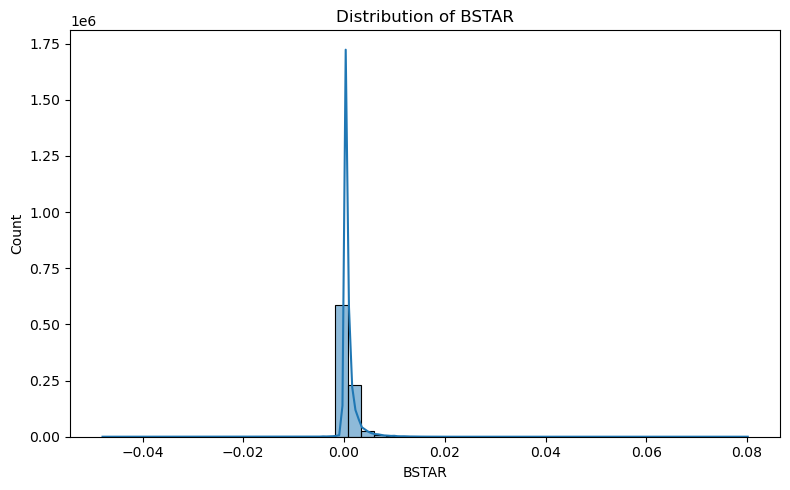

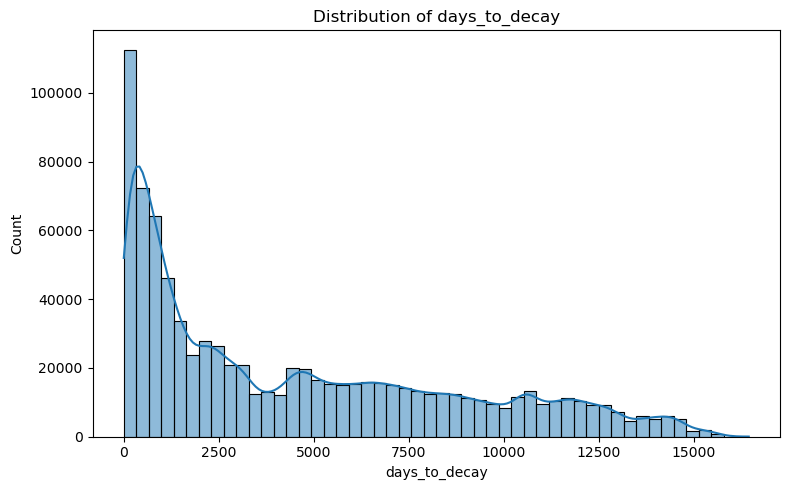

In [17]:
# Feature Distributions
for feature in ['MEAN_MOTION', 'ECCENTRICITY', 'INCLINATION', 'BSTAR', 'days_to_decay']:
    fig, ax = plt.subplots(figsize=(8,5))
    sns.histplot(features_df[feature], bins=50, kde=True, ax=ax)
    ax.set_title(f'Distribution of {feature}')
    plt.tight_layout()

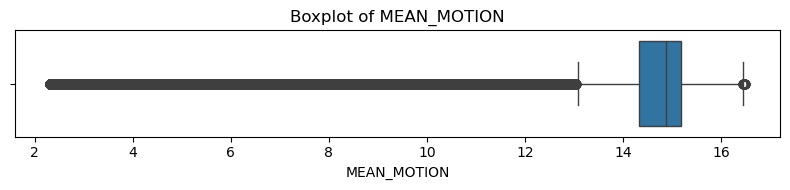

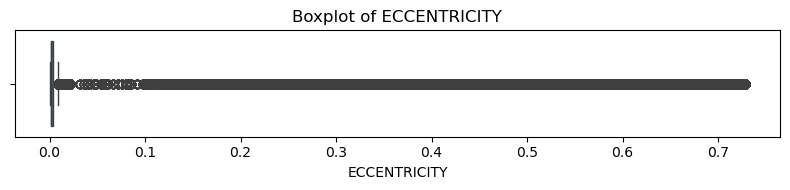

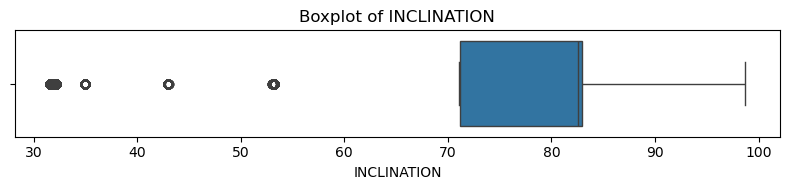

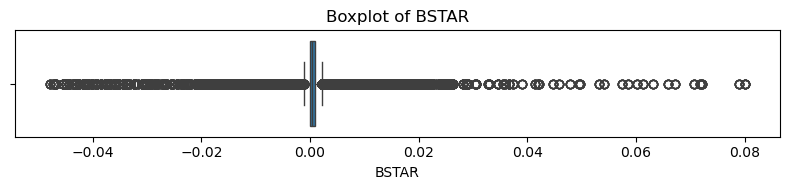

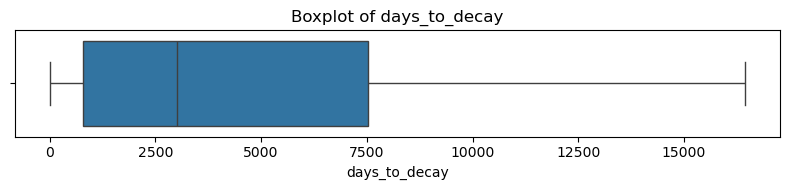

In [18]:
# Boxplots for Outliers
for feature in ['MEAN_MOTION', 'ECCENTRICITY', 'INCLINATION', 'BSTAR', 'days_to_decay']:
    fig, ax = plt.subplots(figsize=(8,2))
    sns.boxplot(x=features_df[feature], ax=ax)
    ax.set_title(f'Boxplot of {feature}')
    plt.tight_layout()

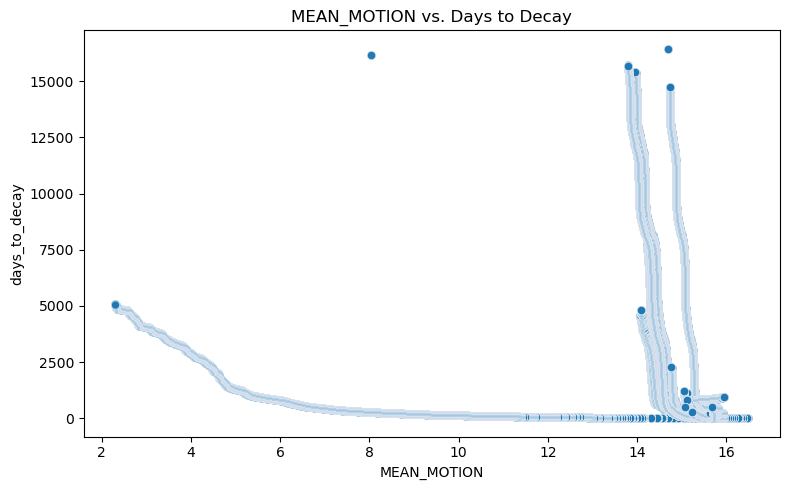

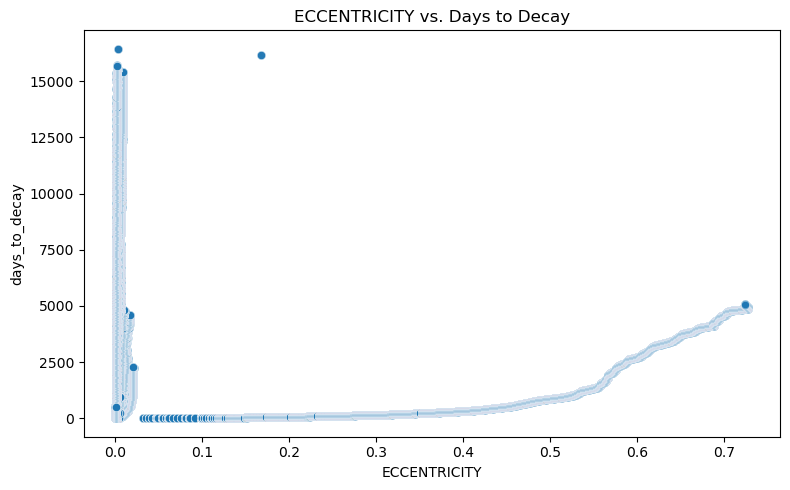

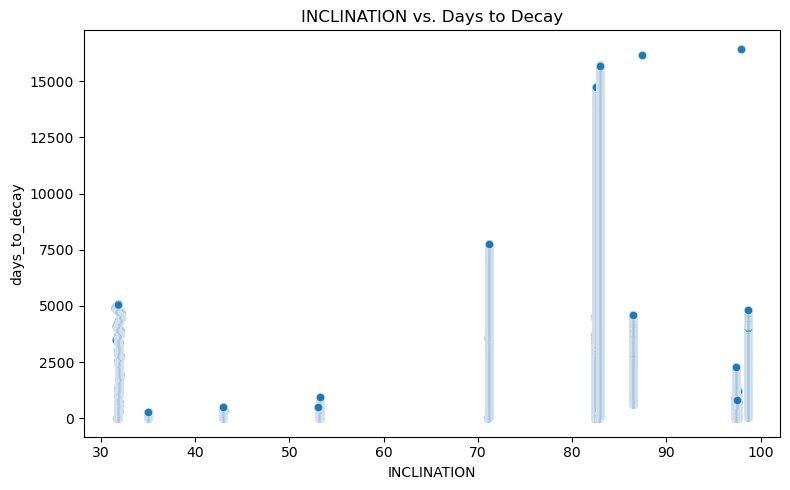

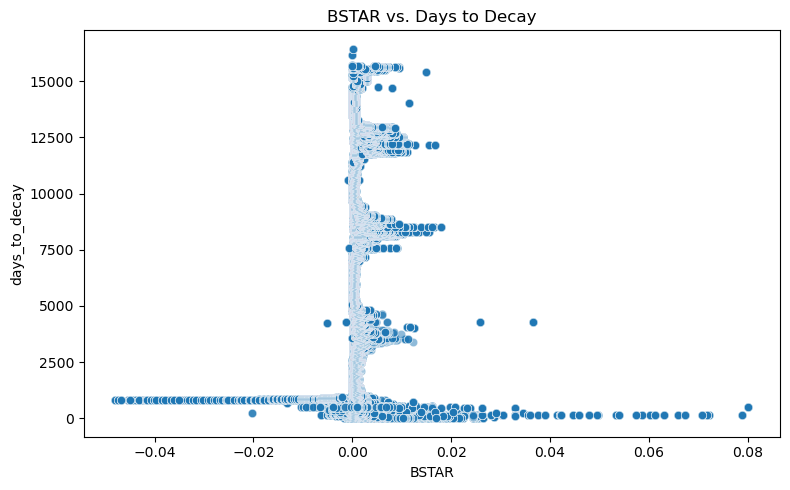

In [19]:
# Scatterplots of Features vs. days_to_decay
for feature in ['MEAN_MOTION', 'ECCENTRICITY', 'INCLINATION', 'BSTAR']:
    fig, ax = plt.subplots(figsize=(8,5))
    sns.scatterplot(x=features_df[feature], y=features_df['days_to_decay'], ax=ax, alpha=0.5)
    ax.set_title(f'{feature} vs. Days to Decay')
    plt.tight_layout()

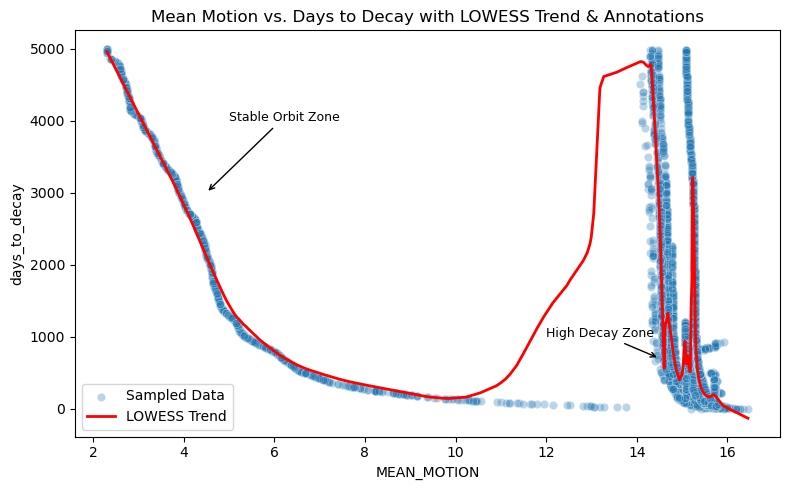

In [33]:
# LOWESS Smoothing
filtered_df = features_df[features_df['days_to_decay'] < 5000].sample(5000, random_state=42)

fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(x='MEAN_MOTION', y='days_to_decay', data=filtered_df, ax=ax, alpha=0.3, label="Sampled Data")

lowess = sm.nonparametric.lowess
z = lowess(filtered_df['days_to_decay'], filtered_df['MEAN_MOTION'], frac=0.1)
ax.plot(z[:, 0], z[:, 1], color='red', linewidth=2, label='LOWESS Trend')

ax.annotate('High Decay Zone', xy=(14.5, 700), xytext=(12, 1000), arrowprops=dict(arrowstyle='->', color='black'), fontsize=9)
ax.annotate('Stable Orbit Zone', xy=(4.5, 3000), xytext=(5, 4000),
            arrowprops=dict(arrowstyle='->', color='black'), fontsize=9)
ax.set_title('Mean Motion vs. Days to Decay with LOWESS Trend & Annotations')
ax.legend()
plt.tight_layout()